In [ ]:
# Trabajar con los datos guadados en drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
Path = "/content/drive/MyDrive/Colab Notebooks/Proyecto_EDSR/"
model_dir="model"
os.makedirs(model_dir, exist_ok=True)

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Proyecto_EDSR/utils.py" "utils.py"
!cp "/content/drive/MyDrive/Colab Notebooks/Proyecto_EDSR/model/common.py" "model/common.py"

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Proyecto_EDSR/data.py" "data.py"
import data

# **Súper resolución con redes neuronales profundas**


El problema de súper resolución consiste basicamente en tomar una imagen en baja resolucion (LR low resolution) y reescalarla de tal manera que obtenemos como salida una imagen en alta resolucion (HR higth resolution). A lo largo del desarrollo de las redes neuronales utilizadas para resolver dicho problema se presenta SRResNet que emplea la arquitectura ResNet, la cual resolivio el problema de súper resolucion ademas de resolver problemas de tiempo y memoria con las que lidiaban algunas redes que intentaron resolver el problema ademas de un buen rendimiento. Sin embargo se considera que la arquitectura ResNet es subóptima para este problema por lo que basados en esto se construye una nueva arquitectura eliminando algunos modulos innecesarios construyendose asi EDSR.


<center>
  <img src = "http://krasserm.github.io/img/2019-09-04/figure_5.png"
       alt    = "comparacion arquitectura"
       title  = " Diseño de bloque residual en ResNet (izquierda) y en EDSR (derecha).">
</center>
<center>Diseño de bloque residual en ResNet (izquierda) y en EDSR (derecha).</center>

## EDSR

Para solucionar dicho problema se utilizara en este caso la arquitectura EDSR (Enhanced Deep Residual Networks for Single Image Super-Resolution) la cual, como se menciono anteriormente,  es una red basada en la arquitectura ResNet en la cual solo se tienen en cuanta los bloques residuales y las capas de muetreo superior eliminando asi la normalizacion por bloque y la capa de activacion final ReLU.


<center>
  <img src = "http://krasserm.github.io/img/2019-09-04/figure_4.png"
       alt    = "EDSR arquitectura"
       title  = "EDSR arquitectura">
</center>
<center>EDSR arquitectura.</center>

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

### Definicion de la capa de bloque residual compuesta por dos capas 
### convolucionales con la funcion de activacion relu

def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

## Definicion de la capa de muetreo superior que permite mediante convoluciones
## recontruir la imagen de manera que se va aumentando la informacion de esta

def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')
        
    return x

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

def normalize(x):
    return (x - DIV2K_RGB_MEAN) / 127.5

def denormalize(x):
    return x * 127.5 + DIV2K_RGB_MEAN

In [ ]:
def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")

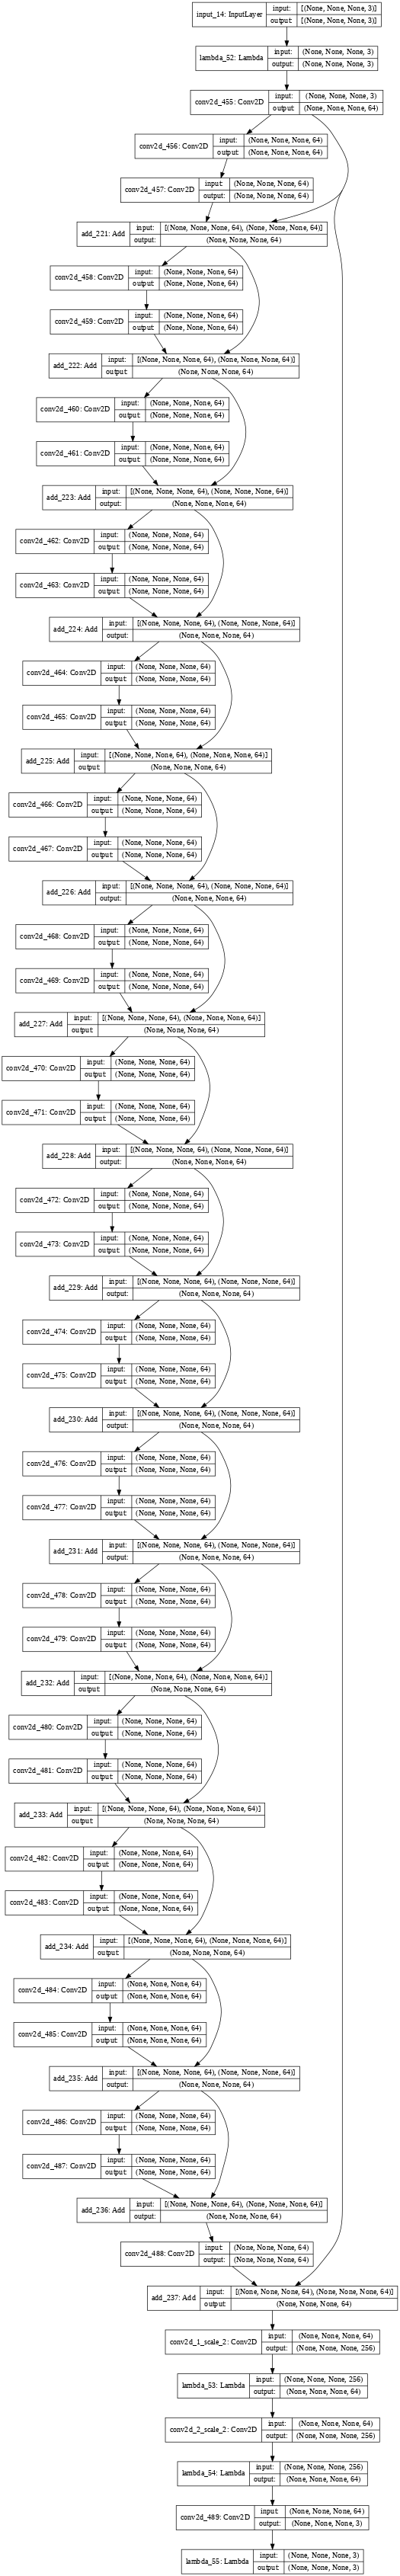

In [ ]:
import os
tf.keras.utils.plot_model(edsr(scale=4, num_res_blocks=16), show_shapes = True, dpi = 50)

## Conjuto de datos

A continuacion se encuentra el conjunto de datos con el cual se llevara acabo el entrenamiento, DIV2K es un un conjunto con datos de gran variedad en donde se encuentran pares de imagenes LR y HR las imagenes LR se obtienen apartir de una reduccion *Bicubic*. Luego se tienen entonces 800 imagenes para el conjunto de entrenamiento y 100 para el conjunto de validacion, a las cuales se le aplican recortes aleatorios, giros y rotaciones con el fin de aumentar la cantidad datos. La funcion **DIV2K** en el modulo **data** proporciona los datos en pares de imagenes LR y HR del conjunto DIV2K en formato *tf.data.Dataset.*


In [ ]:
from data import DIV2K
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

246915072/246914039 [==============================] - 14s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_LR_bicubic_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_bicubic_X4.cache.
3530604544/3530603713 [==============================] - 191s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.


In [ ]:
from data import DIV2K
valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')
valid_ds = valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

31506432/31505881 [==============================] - 3s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X4.cache.
448995328/448993893 [==============================] - 25s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


## Entrenamiento del modelo 

In [ ]:
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

# Crear directorio para guardar los pesos del modelo
weights_dir = Path + 'weights_colab'
os.makedirs(weights_dir, exist_ok=True)

In [ ]:
# base lineal EDSR como se describe en el articulo
model_edsr = edsr(scale=4, num_res_blocks=16)

# Optimizador de Adam con un programador que reduce a la mitad la tasa de aprendizaje después de 7.500 pasos
optim_edsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[7500], values=[1e-4, 5e-5]))

In [ ]:
# Compile y entrene el modelo para 15000 pasos con pérdida de píxeles
model_edsr.compile(optimizer=optim_edsr, loss='mean_absolute_error')
model_edsr.fit(train_ds, epochs=30, steps_per_epoch=500)

# Guardar los pesos del modelo
model_edsr.save_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

Epoch 1/10
50/50 [==============================] - 163s 3s/step - loss: 16.0557
Epoch 2/10
50/50 [==============================] - 158s 3s/step - loss: 14.3130
Epoch 3/10
50/50 [==============================] - 149s 3s/step - loss: 12.3424
Epoch 4/10
50/50 [==============================] - 196s 4s/step - loss: 12.3220
Epoch 5/10
50/50 [==============================] - 196s 4s/step - loss: 11.4899
Epoch 6/10
50/50 [==============================] - 196s 4s/step - loss: 10.9914
Epoch 7/10
50/50 [==============================] - 196s 4s/step - loss: 10.7347
Epoch 8/10
50/50 [==============================] - 196s 4s/step - loss: 10.0562
Epoch 9/10
50/50 [==============================] - 196s 4s/step - loss: 9.9928
Epoch 10/10
50/50 [==============================] - 197s 4s/step - loss: 9.7383


In [ ]:
model_edsr.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
_______________________________________________________________________________________________

In [ ]:
model_edsr.evaluate(valid_ds)

7/7 [==============================] - 26s 4s/step - loss: 9.5749


9.574909210205078

## Pixel Loss

Se utiliza la funcion de perdidad de pixeles la cual corresponde a el error absoluto medio entre la imagen en alta resolucion (valor observado) y la imagen de super resolucion (valor predicho) 

  \begin{align*}
  \mathcal{L}_{pixel, L^1}(I^{HR}, I^{SR}) &= {1 \over {HWC}}
  \lVert I^{HR} - I^{SR} \rVert
  \end{align*}

Donde $H$, $W$ y $C$ son el alto, ancho y numero de canales de la imagen, respectivamente.

#Resultados


In [ ]:
from model.common import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(model,lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

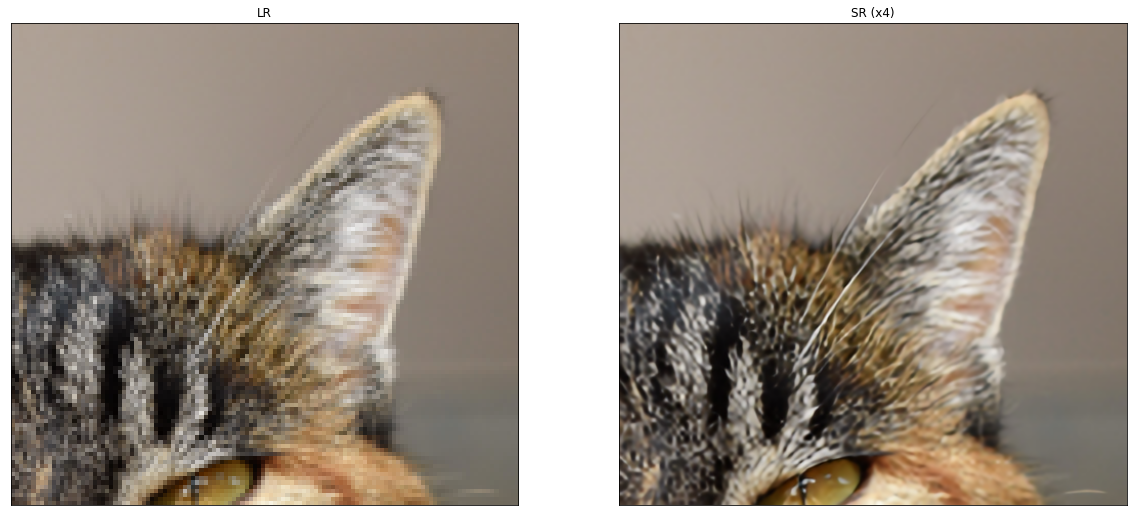

In [ ]:
weights_dir_art = '/content/drive/MyDrive/Colab Notebooks/Proyecto_EDSR/weights_art'
edsr_pre_trained = edsr(scale=4, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir_art, 'weights-edsr-16-x4.h5'))

resolve_and_plot(edsr_pre_trained,Path + 'demo/0869x4-crop.png')

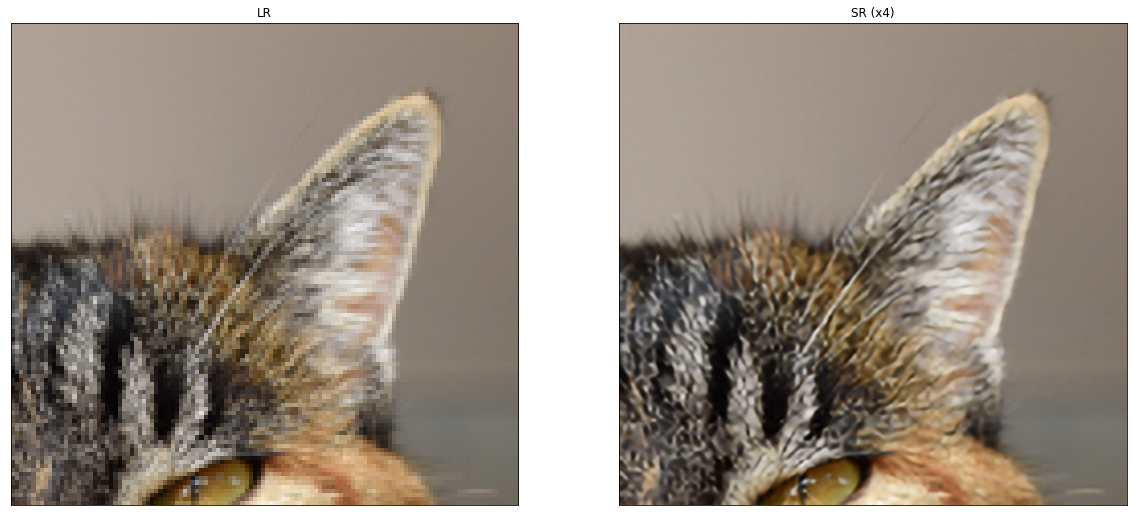

In [ ]:
#weights_dir_art = '/content/drive/MyDrive/Colab Notebooks/Proyecto_EDSR/weights_art'
edsr_pre_trained = edsr(scale=4, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

resolve_and_plot(edsr_pre_trained,Path + 'demo/0869x4-crop.png')

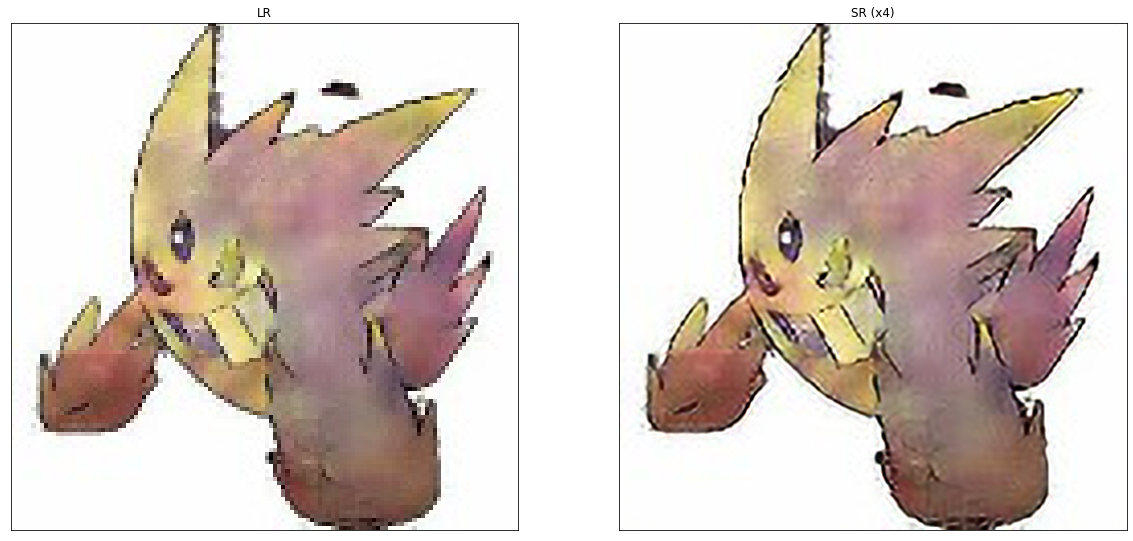

In [ ]:
weights_dir="/content/drive/MyDrive/Colab Notebooks/Proyecto_EDSR/weights"
edsr_pre_trained = edsr(scale=4, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

resolve_and_plot(edsr_pre_trained, Path + 'demo/unnamed3.png')

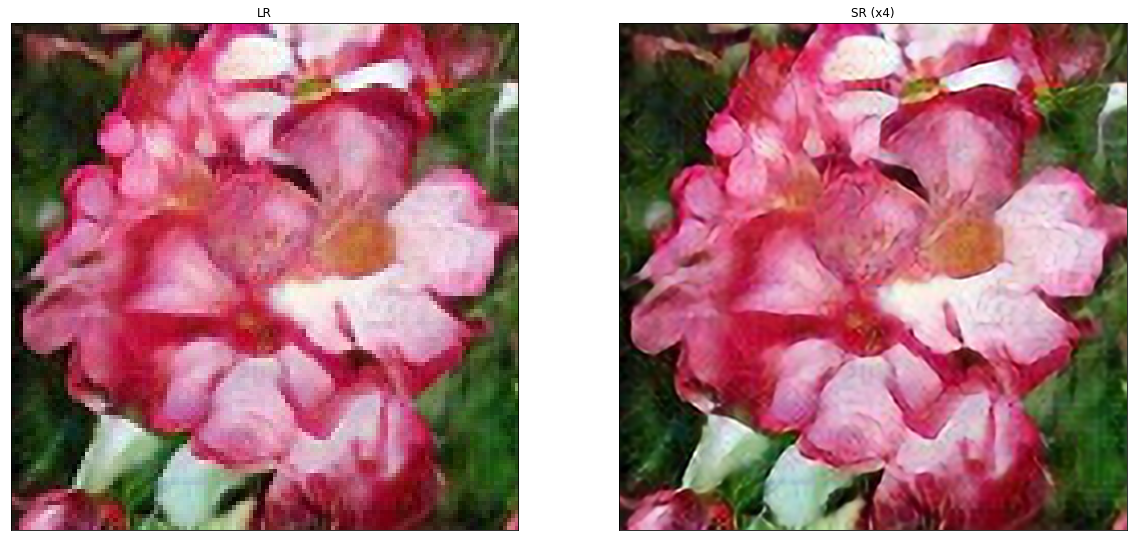

In [ ]:
edsr_pre_trained = edsr(scale=4, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

resolve_and_plot(edsr_pre_trained, Path + 'demo/florinput4.png')